<a target="_blank" href="https://colab.research.google.com/github/tabt/geo_notebooks/blob/main/OpenTopoData_API_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Example of getting elevation data by bbox from OpenTopoData API

API docs: https://www.opentopodata.org/

## Imports

In [1]:
import requests
import numpy as np
from PIL import Image
import json
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np

## Bbox to elevation map functions

In [16]:
def get_elevation_data_bbox(bbox, dataset='aster30m', point_step=0.005):
    """
    Get elevation data for a bounding box from OpenTopoData API.

    Args:
        bbox (tuple): (min_lon, min_lat, max_lon, max_lat)
        dataset (str): name of elevation dataset
        point_step (float): grid step (in degrees) for API requests

    Returns:
        numpy.array: 2D array of elevation values
    """
    min_lon, min_lat, max_lon, max_lat = bbox

    # OpenTopoData API endpoint
    url = f"https://api.opentopodata.org/v1/{dataset}"

    # Number of grid points along each axis
    # It's not very good to use step in degrees, but at least it's easy to implement
    steps_lon = int((max_lon - min_lon) / point_step)
    steps_lat = int((max_lat - min_lat) / point_step)

    # Equally distributed points along each axis
    lons = np.linspace(min_lon, max_lon, steps_lon)
    lats = np.linspace(min_lat, max_lat, steps_lat)

    locations = []
    for lat in lats:
        for lon in lons:
            locations.append(f"{lat},{lon}")

    # API has a limit of 100 locations per request, so we need to batch
    elevation_data = []
    batch_size = 100

    for i in tqdm(range(0, len(locations), batch_size)):
        batch_locations = locations[i:i+batch_size]

        params = {
            'locations': '|'.join(batch_locations)
        }

        response = requests.get(url, params=params)

        if response.status_code == 200:
            data = response.json()
            batch_elevations = [result['elevation'] for result in data['results']]
            elevation_data.extend(batch_elevations)
        else:
            raise Exception(f"API request failed ({response.status_code}): {response.text}")

        # Requests shouldn't be too frequent
        time.sleep(1)

    elevation_array = np.array(elevation_data).reshape(len(lats), len(lons))[::-1]

    return elevation_array, lats, lons

def save_elevation_as_grayscale(elevation_array, output_path):
    """
    Save elevation data as grayscale image.

    Args:
        elevation_array (numpy.array): 2D array of elevation values
        output_path (str): Output file path
    """
    # Normalize elevation to 0-255 range for grayscale
    elevation_min = np.min(elevation_array)
    elevation_max = np.max(elevation_array)

    # Handle case where all elevations are the same
    if elevation_max == elevation_min:
        normalized = np.full_like(elevation_array, 128, dtype=np.uint8)
    else:
        normalized = ((elevation_array - elevation_min) /
                     (elevation_max - elevation_min) * 255).astype(np.uint8)

    # Create and save image
    img = Image.fromarray(normalized)  # mode = 'L'
    img.save(output_path, format='PNG', compress_level=0)  # No compression

    print(f"\nElevation map saved to: {output_path}")
    print(f"Elevation range: {elevation_min:.2f} - {elevation_max:.2f} meters")

## Data retrieval example

**Bbox** could be created manually or via http://bboxfinder.com

**point_step** parameter is a step in degrees to make a grid of requests. Can be smaller to get higher accuracy

**Dataset** is [one from available](https://api.opentopodata.org/datasets) in Open Topo Data API:
Dataset name | Resolution | Extent | Source
---|---|---|---
nzdem8m | 8 m | New Zealand. | LINZ
ned10m | ~10 m | Continental USA, Hawaii, parts of Alaska. | USGS
eudem25m | 25 m | Europe. | EEA
mapzen | ~30 m | Global, inluding bathymetry. | Mapzen
aster30m | ~30 m | Global. | NASA
srtm30m | ~30 m | Latitudes -60 to 60. | USGS
srtm90m | ~90 m | Latitudes -60 to 60. | USGS
bkg200m | 200 m | Germany. | BKG
etopo1 | ~1.8 km | Global, including bathymetry and ice surface elevation near poles. | NOAA
gebco2020 | ~450m | Global bathymetry and land elevation. | GEBCO
emod2018 | ~100m | Bathymetry for ocean and sea in Europe. | EMODnet


In [17]:
# bbox example - the Alps in Austria
bbox = (10.807800, 46.673941, 12.062988, 47.232625)

elevation_data, lats, lons = get_elevation_data_bbox(bbox, dataset='aster30m', point_step=0.005)

# Saving elevation map to file
save_elevation_as_grayscale(elevation_data, "elevation_map.png")

100%|██████████| 279/279 [06:05<00:00,  1.31s/it]


Elevation map saved to: elevation_map.png
Elevation range: 294.00 - 3734.00 meters


## Vizualization

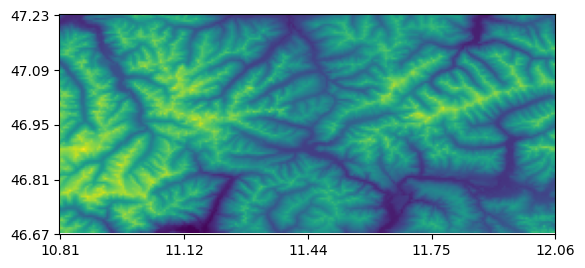

In [18]:
# Preview elevation map
plt.imshow(elevation_data)
plt.xticks(np.linspace(0, elevation_data.shape[1], 5), np.round(np.linspace(lons.min(), lons.max(), 5), 2))
plt.yticks(np.linspace(elevation_data.shape[0], 0, 5), np.round(np.linspace(lats.min(), lats.max(), 5), 2))
plt.show()

In [19]:
# 3D-preview
# Adjust aspectratio and camera if necessary
fig = go.Figure(data=[go.Surface(z=elevation_data[::-1], x=lons, y=lats, colorscale='agsunset')])

fig.update_layout(
    scene=dict(
        xaxis_title='lon',
        yaxis_title='lat',
        zaxis_title='height',
        aspectmode='manual',
        aspectratio={'x': 4, 'y': 3, 'z': 0.5},
        camera=dict(eye=dict(x=0.5, y=-3, z=1.7))
    ),
    height=800
)

fig.show()